In [1]:
import argparse
import json
import os
import time
import ast
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm

from src.dataset import IntendedReceiverDataset
from src.my_model import DualTransformer
from src.utils import calc_class_acc, get_params_str, num_trainable_params

In [2]:
import os, sys
sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))

from src.visualization import plot_action

In [3]:
params = {
    "model": 'transformer',
    "batch_size": 1,
    "n_features": 6,
    "n_classes": 11,
    "context_dim": 32,
    "trans_dim": 256,
    "add_info" : True
    
}

default_device = "cuda:0"
model = nn.DataParallel(DualTransformer(params).to(default_device))
save_path = "saved/{:03d}".format(51)
state_dict = torch.load("{}/model/{}_state_dict_best.pt".format(save_path, params['model']))
model.module.load_state_dict(state_dict)
model = model.eval()

In [4]:
unsuccess_include = False

#실패한 패스를 학습할 때 사용하지 않은 경우
if not unsuccess_include:
    dataset = pd.read_csv('../data/EPV-data/labeling-all-match.csv')

    dataset = dataset[(dataset["eventName"] == "Pass") & (dataset["accurate"] == 0) & (dataset['start_frame'] < dataset['end_frame'])]

    print(dataset.shape)
    dataset = dataset[dataset['no pass'].isna()]
    print(dataset.shape)
    dataset = dataset[dataset['True Intended-receiver'].notna()]
    print(dataset.shape)

    dataset = dataset.drop(columns=['to'])
    dataset = dataset.rename(columns={'True Intended-receiver':'to'})
else:
    #실패한 패스 일부도 학습할 때 사용하는 경우
    dataset = pd.read_csv(f'./{save_path}/unsuccess_test_dataset.csv')    
    print(dataset.shape)

dataset.head(8)

(411, 27)
(367, 27)
(367, 27)


,team,type,subtype,session,start_frame,start_time,end_frame,end_time,from,start_x,...,teamId,eventName,freeze_frame,accurate,value_label,Baseline Intended-Receiver,game_id,event_id,to,no pass
7,Away,BALL LOST,INTERCEPTION,1,346,13.84,380,15.20,B17,55.08,...,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'B18', 'end_x': 34.398, 'end_y...",1,7,B24,NaN
9,Home,BALL LOST,INTERCEPTION,1,378,15.12,452,18.08,A02,29.16,...,1,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'A10', 'end_x': 51.99768, 'end...",1,9,A10,NaN
17,Home,BALL LOST,INTERCEPTION,1,572,22.88,616,24.64,A10,54.00,...,1,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'A08', 'end_x': 60.2208, 'end_...",1,17,A08,NaN
23,Away,BALL LOST,INTERCEPTION,1,1110,44.40,1134,45.36,B17,45.36,...,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'B21', 'end_x': 29.4732, 'end_...",1,23,B21,NaN
28,Home,BALL LOST,INTERCEPTION,1,1370,54.80,1375,55.00,A08,92.88,...,1,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'A09', 'end_x': 95.44284, 'end...",1,28,A09,NaN
46,Away,BALL LOST,INTERCEPTION,1,4489,179.56,4518,180.72,B19,58.32,...,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'B20', 'end_x': 62.1594, 'end_...",1,46,B24,NaN
48,Home,BALL LOST,INTERCEPTION,1,4620,184.80,4679,187.16,A01,39.96,...,1,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'A09', 'end_x': 61.89588, 'end...",1,48,A09,NaN
50,Away,BALL LOST,INTERCEPTION,1,4709,188.36,4749,189.96,B17,64.80,...,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'B23', 'end_x': 38.62188, 'end...",1,50,B23,NaN


In [5]:
dataset[dataset["event_id"] == 865]

,team,type,subtype,session,start_frame,start_time,end_frame,end_time,from,start_x,...,teamId,eventName,freeze_frame,accurate,value_label,Baseline Intended-Receiver,game_id,event_id,to,no pass
865,Away,BALL LOST,INTERCEPTION,1,68406,2736.24,68418,2736.72,B21,48.6,...,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'B23', 'end_x': 28.81872, 'end...",1,865,B24,NaN


In [6]:
nw = len(model.device_ids) * 4
test_dataset = IntendedReceiverDataset(dataset)
print(len(test_dataset))
test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False, num_workers=nw, pin_memory=True)
test_loader

323


In [7]:
losses = []

target_labels = []
predicted_labels = []
predicted_prob = []

for batch_idx, data in tqdm(enumerate(test_loader)):
    passer_input = data[0].to(default_device)
    teammate_input = data[1].to(default_device)
    opponent_input = data[2].to(default_device)
    ball_input = data[3].to(default_device)

    team_poss_input = data[4].to(default_device)
    event_player_input = data[5].to(default_device)

    input = [
        passer_input,
        teammate_input,
        opponent_input,
        ball_input,
        team_poss_input,
        event_player_input,
    ]
    
    passer_mask_list = data[6].to(default_device)
    target = data[7].to(default_device)

    with torch.no_grad():
        out = model(*input)
        
    batch_size, _ = out.shape
    # 모든 값이 0인 mask 생성
    mask = torch.zeros_like(out)
    batch_indices = np.arange(batch_size)
    mask[batch_indices, passer_mask_list] = -np.inf
    out += mask 

    loss = nn.CrossEntropyLoss()(out, target)

    out = torch.softmax(out,dim=1)
    pred = torch.argmax(out).item()

    losses.append(loss.item())
    target_labels.append(target.item())
    predicted_labels.append(pred)  

    #각 선수들의 의도확률도 추출
    predicted_prob.append(out)

best_accuracy = (np.array(target_labels) == np.array(predicted_labels)).mean()

print("loss : ", np.mean(losses))
print("accuracy : ", best_accuracy)

323it [00:04, 70.68it/s]

loss :  0.7959705518380259
accuracy :  0.7058823529411765


In [8]:
# accuracy_lst = []
# def test_model(pt, model, test_loader, default_device):
#     losses = []

#     target_labels = []
#     predicted_labels = []

#     for _, data in tqdm(enumerate(test_loader)):
#         passer_input = data[0].to(default_device)
#         teammate_input = data[1].to(default_device)
#         opponent_input = data[2].to(default_device)
#         ball_input = data[3].to(default_device)

#         team_poss_input = data[4].to(default_device)
#         event_player_input = data[5].to(default_device)

#         input = [
#             passer_input,
#             teammate_input,
#             opponent_input,
#             ball_input,
#             team_poss_input,
#             event_player_input,
#         ]

#         passer_mask_list = data[6].to(default_device)
#         target = data[7].to(default_device)

#         with torch.no_grad():
#             out = model(*input)
            
#         batch_size, _ = out.shape
#         # 모든 값이 0인 mask 생성
#         mask = torch.zeros_like(out)
#         batch_indices = np.arange(batch_size)
#         mask[batch_indices, passer_mask_list] = -np.inf
#         out += mask 

#         loss = nn.CrossEntropyLoss()(out, target)

#         out = torch.softmax(out,dim=1)
#         pred = torch.argmax(out).item()

#         losses.append(loss)
#         target_labels.append(target.item())
#         predicted_labels.append(pred)  

#     accuracy = (np.array(target_labels) == np.array(predicted_labels)).mean()
#     accuracy_lst.append(accuracy.round(4))

# max_pt = 350
# for pt in tqdm(range(10, max_pt+1, 10)):
#     state_dict = torch.load("{}/model/{}_state_dict_{}.pt".format(save_path, params['model'], pt))
#     model.module.load_state_dict(state_dict)
#     model = model.eval()

#     test_model(pt, model, test_loader, default_device)

# plt.figure(figsize=(12, 7))

# x_coords = list(range(10, max_pt+1, 10))
# x_ticks = [str(epoch) if epoch % 50 == 0 or epoch == max_pt else '' for epoch in range(10, max_pt+1, 10)]

# plt.plot(x_coords, accuracy_lst, label='Epoch Accuracy', marker='o', zorder=3)

# plt.scatter(24, best_accuracy, color='red', label='Best Model Epoch', zorder=5)
# plt.axhline(y=best_accuracy, color='red', linestyle='--', label='Best Model Accuracy', zorder=2)
# # Best Model 점 표시

# plt.title('unsuccess pass evaluation')
# plt.xlabel('Epoch')
# #plt.xticks(x_coords, x_ticks, rotation=45)  # 'best' 라벨 제외
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [9]:
import ast

print("error index : ", len(test_dataset.except_index))

correct_test_dataset = dataset[~dataset['event_id'].isin(test_dataset.except_index)]
correct_test_dataset["freeze_frame"] = correct_test_dataset["freeze_frame"].apply(ast.literal_eval)
correct_test_dataset["Baseline Intended-Receiver"] = correct_test_dataset["Baseline Intended-Receiver"].apply(ast.literal_eval)
print(correct_test_dataset.shape)

correct_test_dataset.head()

error index :  44
(323, 26)


/tmp/ipykernel_1996986/2744497011.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_test_dataset["freeze_frame"] = correct_test_dataset["freeze_frame"].apply(ast.literal_eval)
/tmp/ipykernel_1996986/2744497011.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_test_dataset["Baseline Intended-Receiver"] = correct_test_dataset["Baseline Intended-Receiver"].apply(ast.literal_eval)


,team,type,subtype,session,start_frame,start_time,end_frame,end_time,from,start_x,...,teamId,eventName,freeze_frame,accurate,value_label,Baseline Intended-Receiver,game_id,event_id,to,no pass
7,Away,BALL LOST,INTERCEPTION,1,346,13.84,380,15.20,B17,55.08,...,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'B18', 'end_x': 34.398, 'end_y...",1,7,B24,NaN
9,Home,BALL LOST,INTERCEPTION,1,378,15.12,452,18.08,A02,29.16,...,1,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'A10', 'end_x': 51.99768, 'end...",1,9,A10,NaN
17,Home,BALL LOST,INTERCEPTION,1,572,22.88,616,24.64,A10,54.00,...,1,Pass,"{'A11': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'A08', 'end_x': 60.2208, 'end_...",1,17,A08,NaN
23,Away,BALL LOST,INTERCEPTION,1,1110,44.40,1134,45.36,B17,45.36,...,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'B21', 'end_x': 29.4732, 'end_...",1,23,B21,NaN
46,Away,BALL LOST,INTERCEPTION,1,4489,179.56,4518,180.72,B19,58.32,...,2,Pass,"{'B25': {'teammate': True, 'actor': False, 'ba...",0.0,0,"{'dist': {'ID': 'B20', 'end_x': 62.1594, 'end_...",1,46,B24,NaN


In [10]:
# 각 방식에 대한 정확도 계산
methods = ['dist', 'dist and angle', 'dist and narrow angle']

# 정확도를 계산하는 함수
def calculate_accuracy(events, method):
    correct_predictions = events.apply(lambda row: row['Baseline Intended-Receiver'][method]['ID'] == row['to'], axis=1)
    accuracy = correct_predictions.mean()
    return accuracy

accuracies = {method: calculate_accuracy(correct_test_dataset, method) for method in methods}
accuracies

{'dist': 0.7368421052631579,
 'dist and angle': 0.6811145510835913,
 'dist and narrow angle': 0.4891640866873065}

In [11]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

game_ids = correct_test_dataset['game_id'].unique()

traces_dict = {}
for game_id in game_ids:
    traces = pd.read_csv(f'../data/preprocess-data/tracking-data/match{game_id}.csv')
    traces.set_index('frame',inplace=True)
    traces_dict[game_id] = traces

In [12]:
correct_test_dataset["True Intended-receiver"] = np.nan
correct_test_dataset["Pred Intended-receiver"] = np.nan
correct_test_dataset["Pred Intended-prob"] = {}

for i,(idx, row) in tqdm(enumerate(correct_test_dataset.iterrows())):
    game_id = row['game_id']
    traces = traces_dict[game_id]

    start_frame = row['start_frame']
    session = traces.at[start_frame,'session']
    frame_traces = traces.loc[start_frame-60 + 1 : start_frame+20]
    frame_traces = frame_traces[frame_traces['session'] == session]

    passer = row['from']
    team = passer[0]
    receiver = row['to']

    player_cols = [f"{c[:3]}{t}" for c in frame_traces.dropna(axis=1).columns if c.endswith("_speed") for t in test_dataset.feature_types]
    player_cols = sorted(player_cols, key=lambda c: (c[:3], test_dataset.feature_types.index(c[3:])))

    player_names = [c[:3] for c in player_cols if c.endswith("_x") and c[0] == team]
    label_dict = {idx:col for idx, col in enumerate(player_names)}   
    
    correct_test_dataset.at[idx,'True Intended-receiver'] = label_dict[target_labels[i]]
    correct_test_dataset.at[idx,'Pred Intended-receiver'] = label_dict[predicted_labels[i]]
    
    intended_prob = predicted_prob[i].squeeze()
    player_intended_prob = {label_dict[i] : float(intended_prob[i]) for i in range(len(intended_prob))} 
    correct_test_dataset.at[idx,'Pred Intended-prob'] = player_intended_prob

323it [00:00, 847.68it/s]


In [18]:
correct_test_dataset[correct_test_dataset["event_id"] == 865]

,team,type,subtype,session,start_frame,start_time,end_frame,end_time,from,start_x,...,accurate,value_label,Baseline Intended-Receiver,game_id,event_id,to,no pass,True Intended-receiver,Pred Intended-receiver,Pred Intended-prob
865,Away,BALL LOST,INTERCEPTION,1,68406,2736.24,68418,2736.72,B21,48.6,...,0.0,0,"{'dist': {'ID': 'B23', 'end_x': 28.81872, 'end...",1,865,B24,NaN,B24,B23,"{'B15': 5.955431333859451e-06, 'B16': 3.565955..."


In [19]:
i = 865
data = pd.DataFrame.from_dict(correct_test_dataset.loc[i,"Pred Intended-prob"],orient='index')

# 각 값의 합을 계산
total = sum(data.values)

# 각 값이 전체에서 차지하는 비율을 %로 계산하고, 소수점 네 자리까지 반올림
percentages = {key: round((value / total) * 100, 4) for key, value in data.items()}
percentages

{0: B15     0.0006
 B16     0.0004
 B17     0.0000
 B18     0.0481
 B19     0.0257
 B20     0.0203
 B21     0.0000
 B22     0.0131
 B23    98.6260
 B24     1.2408
 B25     0.0249
 Name: 0, dtype: float64}

<Axes: title={'center': 'Fail BALL LOST(INTERCEPTION) \nB21 -> nan\ndist = B23\ndist and angle = B23\ndist and narrow angle = B23\ntrue_receiver = B24\npred_receiver = B23\n'}>

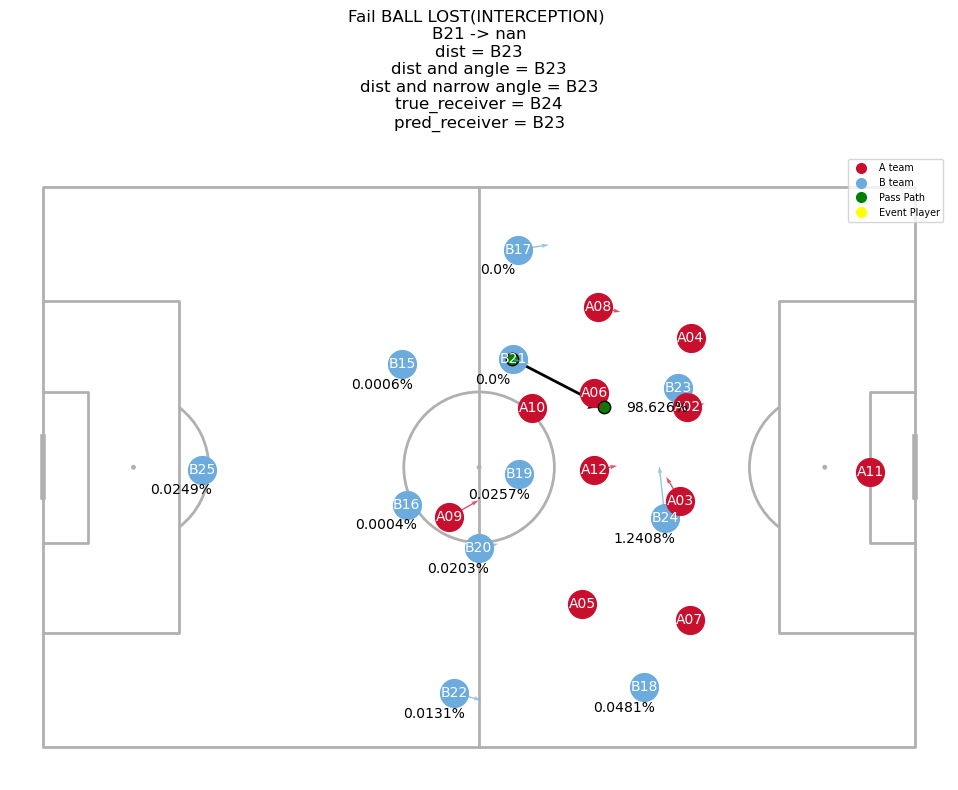

In [20]:
plot_action(correct_test_dataset.loc[865],left_to_right=True,intended_prob_dict=correct_test_dataset.loc[i,"Pred Intended-prob"])

In [21]:
from src.labels import get_nearest_receiver

correct_test_dataset = get_nearest_receiver(correct_test_dataset, traces_dict)

# 각 방식에 대한 정확도 계산
methods = ['dist_nearest', 'angle_nearest', 'dist and angle']

# 정확도를 계산하는 함수
def calculate_accuracy(events, method, label="to"):
    correct_predictions = events.apply(lambda row: row['Intended_Receiver'][method]['ID'] == row[label], axis=1)
    accuracy = correct_predictions.mean()
    return accuracy

accuracy = {method: calculate_accuracy(correct_test_dataset, method) for method in methods}
accuracy

{'dist_nearest': 0.15789473684210525,
 'angle_nearest': 0.5356037151702786,
 'dist and angle': 0.5139318885448917}

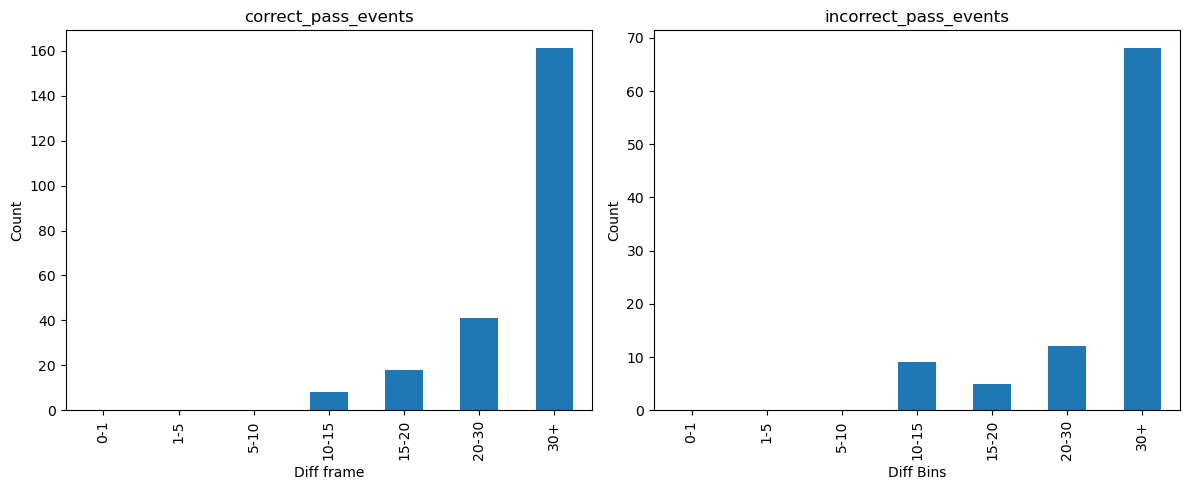

In [22]:
# 가정: 두 데이터프레임이 pass_events1과 pass_events2로 주어져 있다고 가정합니다.
# 이 예제 코드는 두 데이터프레임에 대해 동일한 처리를 적용한 후 결과를 양 옆으로 나란히 표시하는 방법을 보여줍니다.

correct_pass_events = correct_test_dataset[correct_test_dataset['True Intended-receiver'] == correct_test_dataset['Pred Intended-receiver']]
incorrect_pass_events = correct_test_dataset[correct_test_dataset['True Intended-receiver'] != correct_test_dataset['Pred Intended-receiver']]
# frame_diff 계산
correct_pass_events['frame_diff'] = correct_pass_events['end_frame'] - correct_pass_events['start_frame']
incorrect_pass_events['frame_diff'] = incorrect_pass_events['end_frame'] - incorrect_pass_events['start_frame']

# bins 설정
bins = [0, 1, 5, 10, 15, 20, 30, max(correct_pass_events['frame_diff'].max(), incorrect_pass_events['frame_diff'].max())]

# diff 데이터를 bins에 따라 분류
correct_pass_events['binned_diff'] = pd.cut(correct_pass_events['frame_diff'], bins=bins, right=False, labels=["0-1", "1-5","5-10", "10-15","15-20", "20-30", "30+"])
incorrect_pass_events['binned_diff'] = pd.cut(incorrect_pass_events['frame_diff'], bins=bins, right=False, labels=["0-1", "1-5","5-10", "10-15","15-20", "20-30", "30+"])

# 플롯 준비
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# 첫 번째 데이터프레임의 히스토그램
correct_pass_events['binned_diff'].value_counts().sort_index().plot(kind='bar', ax=axes[0])
axes[0].set_title('correct_pass_events')
axes[0].set_xlabel('Diff frame')
axes[0].set_ylabel('Count')

# 두 번째 데이터프레임의 히스토그램
incorrect_pass_events['binned_diff'].value_counts().sort_index().plot(kind='bar', ax=axes[1])
axes[1].set_title('incorrect_pass_events')
axes[1].set_xlabel('Diff Bins')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


### 모델의 입출력에 문제가 있는지 검증

1. type_true가 to과 다른 경우
2. type_pred(intended-receiver)를 opponent로 예측한 경우
3. type_pred를 passer로 예측한 경우

In [23]:
correct_test_dataset[correct_test_dataset['to'] != correct_test_dataset['True Intended-receiver']]

,team,type,subtype,session,start_frame,start_time,end_frame,end_time,from,start_x,...,value_label,Baseline Intended-Receiver,game_id,event_id,to,no pass,True Intended-receiver,Pred Intended-receiver,Pred Intended-prob,Intended_Receiver


In [24]:
correct_test_dataset[correct_test_dataset.apply(lambda row: row['to'][0] != row['Pred Intended-receiver'][0], axis=1)]

,team,type,subtype,session,start_frame,start_time,end_frame,end_time,from,start_x,...,value_label,Baseline Intended-Receiver,game_id,event_id,to,no pass,True Intended-receiver,Pred Intended-receiver,Pred Intended-prob,Intended_Receiver


In [25]:
print(correct_test_dataset.shape)
print(correct_test_dataset[correct_test_dataset.apply(lambda row: row['from'] == row['Pred Intended-receiver'], axis=1)].shape)
correct_test_dataset[correct_test_dataset.apply(lambda row: row['from'] == row['Pred Intended-receiver'], axis=1)]

(323, 30)
(0, 30)


,team,type,subtype,session,start_frame,start_time,end_frame,end_time,from,start_x,...,value_label,Baseline Intended-Receiver,game_id,event_id,to,no pass,True Intended-receiver,Pred Intended-receiver,Pred Intended-prob,Intended_Receiver


In [26]:
correct_test_dataset[correct_test_dataset['True Intended-receiver'] != correct_test_dataset['Pred Intended-receiver']].head()

,team,type,subtype,session,start_frame,start_time,end_frame,end_time,from,start_x,...,value_label,Baseline Intended-Receiver,game_id,event_id,to,no pass,True Intended-receiver,Pred Intended-receiver,Pred Intended-prob,Intended_Receiver
9,Home,BALL LOST,INTERCEPTION,1,378,15.12,452,18.08,A02,29.16,...,0,"{'dist': {'ID': 'A10', 'end_x': 51.99768, 'end...",1,9,A10,NaN,A10,A06,"{'A01': 3.2986601581797004e-05, 'A02': 0.0, 'A...","{'dist_nearest': {'ID': 'A03', 'end_x': 24.845..."
48,Home,BALL LOST,INTERCEPTION,1,4620,184.80,4679,187.16,A01,39.96,...,0,"{'dist': {'ID': 'A09', 'end_x': 61.89588, 'end...",1,48,A09,NaN,A09,A05,"{'A01': 0.0, 'A02': 3.15715169563191e-07, 'A03...","{'dist_nearest': {'ID': 'A02', 'end_x': 29.600..."
112,Home,BALL LOST,GOAL KICK-INTERCEPTION,1,8482,339.28,8576,343.04,A11,4.32,...,0,"{'dist': {'ID': 'A10', 'end_x': 61.49628, 'end...",1,112,A10,NaN,A10,A08,"{'A01': 0.006258257199078798, 'A02': 0.0105420...","{'dist_nearest': {'ID': 'A03', 'end_x': 42.285..."
170,Home,BALL LOST,INTERCEPTION,1,13672,546.88,13701,548.04,A01,44.28,...,0,"{'dist': {'ID': 'A10', 'end_x': 62.98344, 'end...",1,170,A10,NaN,A10,A05,"{'A01': 0.0, 'A02': 8.916553895232937e-08, 'A0...","{'dist_nearest': {'ID': 'A05', 'end_x': 49.069..."
187,Home,BALL LOST,INTERCEPTION,1,14730,589.20,14741,589.64,A08,104.76,...,0,"{'dist': {'ID': 'A09', 'end_x': 97.45164, 'end...",1,187,A09,NaN,A09,A05,"{'A01': 0.00035236828261986375, 'A02': 7.16237...","{'dist_nearest': {'ID': 'A09', 'end_x': 97.451..."


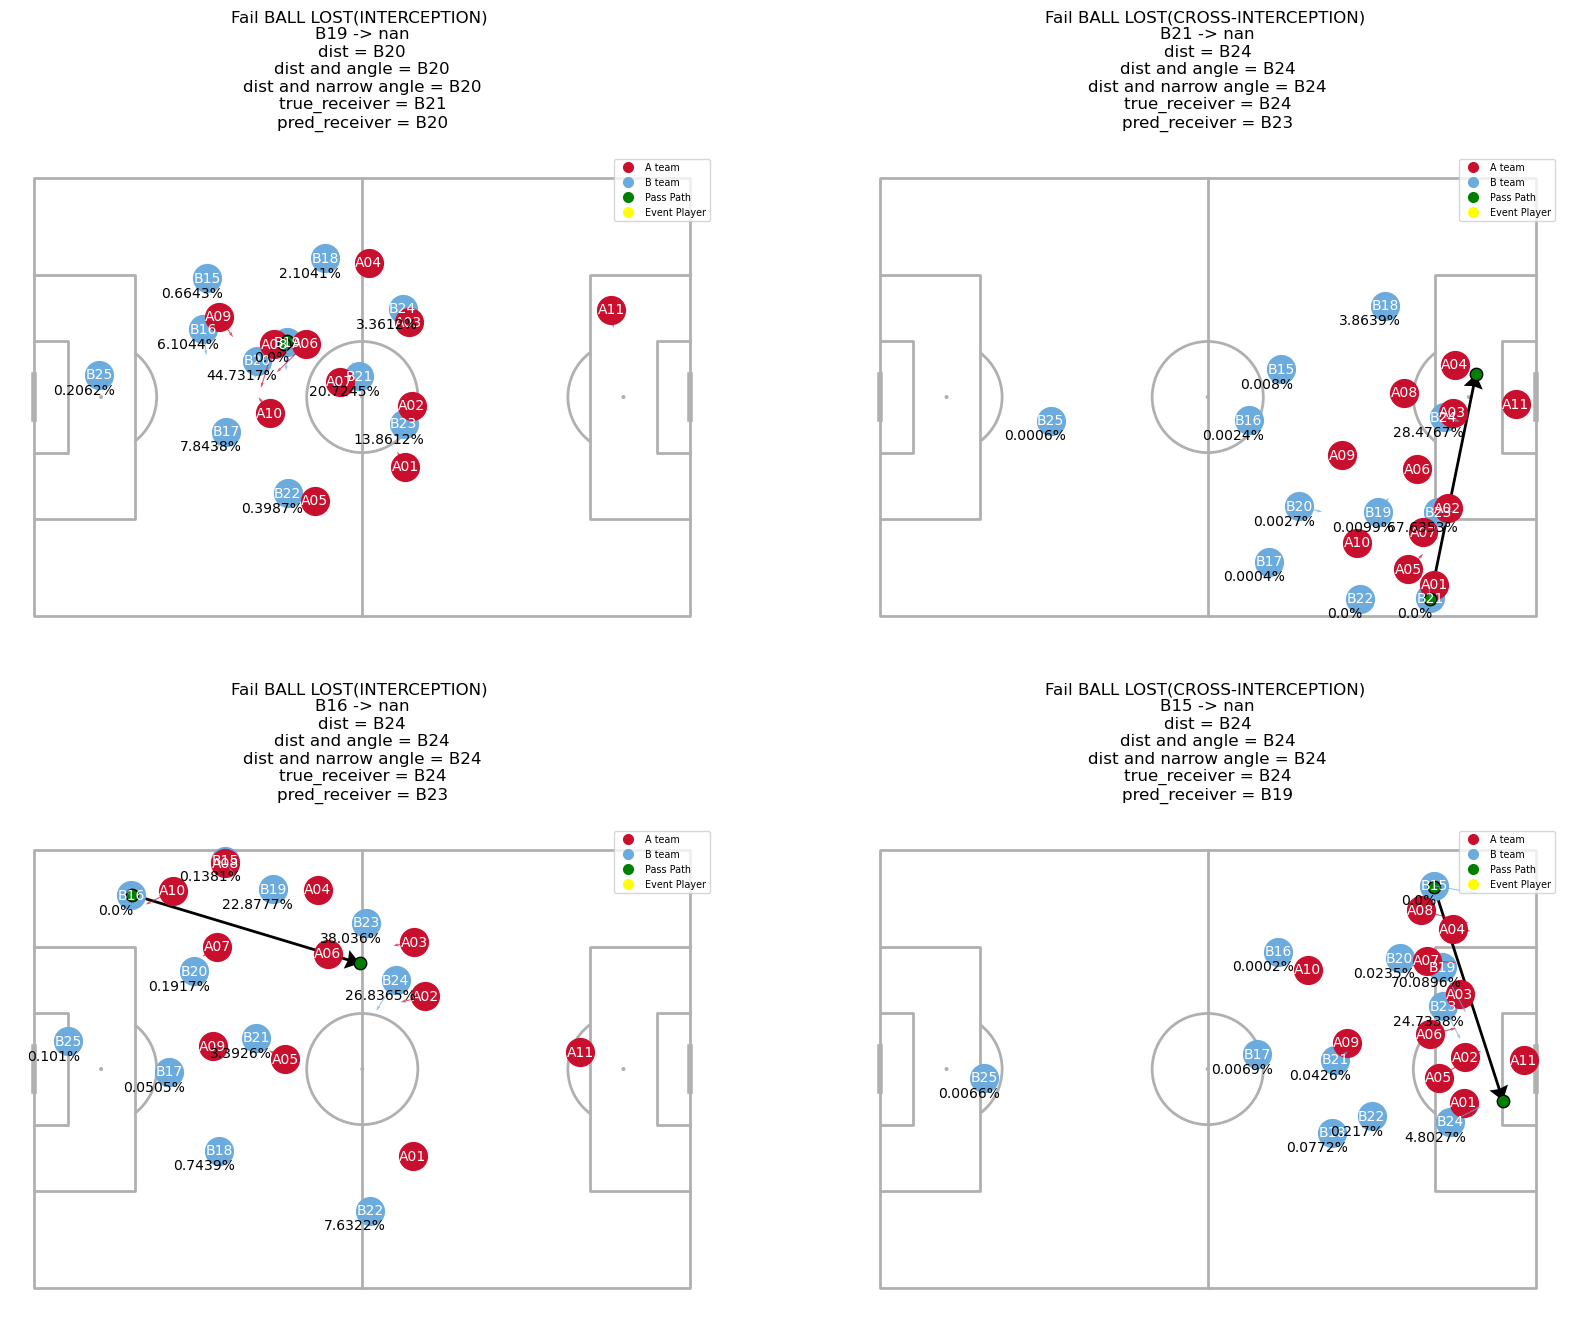

In [28]:
event_ids = [408, 393, 1762, 2291]

fig, ax = plt.subplots(2,2,figsize=(20,16))

ax_id = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]] 

for i, event_id in enumerate(event_ids):
    index = correct_test_dataset[correct_test_dataset['event_id'] == event_id].index[0]
    record = correct_test_dataset.loc[index]
    plot_action(record, ax=ax_id[i],field_dimen=(108,72),intended_prob_dict=record["Pred Intended-prob"])

plt.show()